In [ ]:
import os
import argparse
import pandas as pd
import numpy as np
from keras.models import Model
from keras import Input, Model, layers, regularizers, callbacks
from keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import sys
sys.path.insert(0, '/Users/huripari/Documents/PhD/TCs_Genesis/tcg_fsM')
import utils_results as ut

In [19]:
basin = 'GLB'
run_name = 'selfeat75_top20_nc10_nv8_nd9'
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
n_clusters = int(run_name.split('nc')[1].split('_')[0])
n_vars = int(run_name.split('nv')[1].split('_')[0])
n_idxs = int(run_name.split('nd')[1].split('_')[0])
model_kind = run_name.split('_')[1]

In [ ]:
# Set project directory and name of file containing the target variable
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
target_file = 'target_1970-2022_2.5x2.5.csv'
# Retrieve the clusters type of data from the results folder
nc_string = run_name.split('_')[2]
if "A" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_anomaly'
elif "DS" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
else:
    cluster_data = f'{basin}_{n_clusters}clusters'
# Set the paths to the files
experiment_filename = f'1970-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
predictor_file = 'predictors_' + experiment_filename
fs_dir = os.path.join(project_dir, 'tcg_fsM')
results_dir = os.path.join(fs_dir, 'results')
output_dir = os.path.join(results_dir, basin, run_name)
data_dir = os.path.join(fs_dir, 'data', cluster_data)
predictors_path = os.path.join(data_dir, predictor_file)
final_analysis_dir = os.path.join(output_dir, 'final_analysis')
os.makedirs(final_analysis_dir, exist_ok=True)
target_path = os.path.join(data_dir, target_file)
gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')
# Load the predictors and the target in a DataFrame
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)
if "DS" in nc_string:
    target_season_df = pd.read_csv(os.path.join(data_dir, target_season), index_col=0)
    target_season_df.index = pd.to_datetime(target_season_df.index)
# Load the gpis time series dataframe and select the target GPIs for physical information to pass to the network
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpi_pi = gpis_df['ogpi']

In [21]:
# Load the best solution file if it is a test run
if "test" in run_name:
    sol_filename = f'{model_kind}_' + experiment_filename
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    # Load the solutions file in a DataFrame and the best solution found
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    best_solution = best_solution.to_numpy().flatten()
    # Select the variables from the best solutions
    column_names = predictors_df.columns.tolist()
    final_sequence = best_solution[len(column_names):2*len(column_names)]
    sequence_length = best_solution[:len(column_names)]
    feat_sel = best_solution[2*len(column_names):]
else:
    os.makedirs(output_dir, exist_ok=True)

In [22]:
# Create dataset according to solution and list the labels of the selected variables
if "test" in run_name:
    variable_selection = feat_sel.astype(int)
    time_sequences = sequence_length.astype(int)
    time_lags = final_sequence.astype(int)
    dataset_opt = target_df.copy()
    for c, col in enumerate(predictors_df.columns):
        if variable_selection[c] == 0 or time_sequences[c] == 0:
            continue
        for j in range(time_sequences[c]):
            dataset_opt[str(col) +'_lag'+ str(time_lags[c]+j)] = predictors_df[col].shift(time_lags[c]+j)
else:
    # features selected >= sel_perc% of the time in the top20% best models
    sel_feat_perc_path = os.path.join(results_dir, f'selected_features_best_models_{basin}_{nc_string}.csv')
    df_sel_feat_perc = pd.read_csv(sel_feat_perc_path, index_col=0)
    sel_perc = run_name.split('_')[0].split('selfeat')[1]
    selected_features = df_sel_feat_perc[sel_perc].dropna().to_list()
    dataset_opt = predictors_df[selected_features]
    dataset_opt.columns = [f'{feat}_lag0' for feat in dataset_opt.columns]
    dataset_opt = dataset_opt.assign(tcg=target_df['tcg'])
# Compone the dataset to train the model using all predictors possible
dataset_opt_noFS = target_df.copy()
for l in range(1):
    for var in predictors_df.columns:
        col_df = pd.DataFrame(predictors_df[var].shift(l).values, index=dataset_opt_noFS.index, columns=[f'{var}_lag{l}'])
        dataset_opt_noFS = pd.concat([dataset_opt_noFS, col_df], axis=1)

In [23]:
## Train MLPregressor with the best solution found ##
# Cross-Validation for train and test years
kfold = KFold(n_splits=n_folds)
Y_column = 'tcg' # Target variable
Y_pred_df = pd.DataFrame()
Y_pred_noFS_df = pd.DataFrame()
Y_test_df = pd.DataFrame()

for n_fold, (train_index, test_index) in enumerate(kfold.split(years)):

    # Set the indices for the training and test datasets
    train_years = years[train_index]
    test_years = years[test_index]
    # Split the optimized dataset
    train_indices = dataset_opt.index.year.isin(train_years)
    test_indices = dataset_opt.index.year.isin(test_years)
    train_dataset = dataset_opt[train_indices]
    test_dataset = dataset_opt[test_indices]
    # Split the entire dataset 
    train_indices_noFS = dataset_opt_noFS.index.year.isin(train_years)
    test_indices_noFS = dataset_opt_noFS.index.year.isin(test_years)
    train_dataset_noFS = dataset_opt_noFS[train_indices_noFS]
    test_dataset_noFS = dataset_opt_noFS[test_indices_noFS]
    # Split the gpis dataset
    gpi_pi_train = gpi_pi[train_indices]
    gpi_pi_test = gpi_pi[test_indices]

    # Standardize the optimized dataset
    X_train = train_dataset[train_dataset.columns.drop([Y_column])]
    Y_train = train_dataset[Y_column]
    X_test_fold = test_dataset[test_dataset.columns.drop([Y_column])]
    Y_test_fold = test_dataset[Y_column]
    scaler = preprocessing.MinMaxScaler()
    X_std_train = scaler.fit(X_train)
    X_std_train = scaler.transform(X_train)
    X_std_test = scaler.transform(X_test_fold)
    X_train = pd.DataFrame(X_std_train, columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(X_std_test, columns=X_test_fold.columns, index=X_test_fold.index)
    # Standardize the entire dataset
    X_train_noFS = train_dataset_noFS[train_dataset_noFS.columns.drop([Y_column])]
    X_test_fold_noFS = test_dataset_noFS[test_dataset_noFS.columns.drop([Y_column])]
    scaler_noFS = preprocessing.MinMaxScaler()
    X_std_train_noFS = scaler_noFS.fit(X_train_noFS)
    X_std_train_noFS = scaler_noFS.transform(X_train_noFS)
    X_std_test_noFS = scaler_noFS.transform(X_test_fold_noFS)
    X_train_noFS = pd.DataFrame(X_std_train_noFS, columns=X_train_noFS.columns, index=X_train_noFS.index)
    X_test_noFS = pd.DataFrame(X_std_test_noFS, columns=X_test_fold_noFS.columns, index=X_test_fold_noFS.index)

    # Split the training set in training and validation sets for all models and both datasets
    X_t, X_v, Y_t, Y_v, X_t_noFS, X_v_noFS, gpi_pi_t, gpi_pi_v = train_test_split(X_train, Y_train, X_train_noFS, gpi_pi_train, test_size=0.2, random_state=42)

    Y_test_df = pd.concat([Y_test_df, Y_test_fold])

    ## Define common training parameters and callbacks for the mlp ##
    n_neurons = 64
    epo = 100 # Number of epochs
    lr = 0.001 # Learning rate
    l2_reg = 0.001
    batch_size = 32
    callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ## MLPregressor with Selected Features ##
    # Build and compile the multi layer perceptron model for the optimized dataset
    n_predictors = len(X_train.columns)
    inputs = Input(shape=(n_predictors,))
    x = layers.Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    output = layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg))(x)
    mlpreg = Model(inputs, output)
    mlpreg.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    # Train the model
    history = mlpreg.fit(X_t, Y_t, validation_data=(X_v, Y_v), epochs=epo, batch_size=batch_size, callbacks=[callback], verbose=0)
    # Evaluate the model
    Y_pred_fold = mlpreg.predict(X_test, verbose=0)
    Y_pred_fold = pd.DataFrame(Y_pred_fold, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_df = pd.concat([Y_pred_df, Y_pred_fold])
    loss = mlpreg.evaluate(X_test, Y_test_fold, verbose=0)
    ## MLPregressor with all Features ##
    # Build and compile the multi layer perceptron model for the entire dataset
    n_predictors_noFS = len(X_train_noFS.columns)
    inputs_noFS = Input(shape=(n_predictors_noFS,))
    x_noFS = layers.Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs_noFS)
    output_noFS = layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg))(x_noFS)
    mlpreg_noFS = Model(inputs_noFS, output_noFS)
    mlpreg_noFS.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    # Train the model
    history_noFS = mlpreg_noFS.fit(X_t_noFS, Y_t, validation_data=(X_v_noFS, Y_v), epochs=epo, batch_size=batch_size, callbacks=[callback], verbose=0)
    # Evaluate the model
    Y_pred_fold_noFS = mlpreg_noFS.predict(X_test_noFS, verbose=0)
    Y_pred_fold_noFS = pd.DataFrame(Y_pred_fold_noFS, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_noFS_df = pd.concat([Y_pred_noFS_df, Y_pred_fold_noFS])
    loss_noFS = mlpreg_noFS.evaluate(X_test_noFS, Y_test_fold, verbose=0)
    ## Plot the training and validation loss for the 2 models ##
    fig = ut.plot_train_val_loss(history.history['loss'], history.history['val_loss'], history_noFS.history['loss'], history_noFS.history['val_loss'], loss, loss_noFS)
    plt.show()

/var/folders/4j/mk5kjh194fb26fgn4j6prnb80000gn/T/ipykernel_9814/3440032139.py:52: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  Y_test_df = pd.concat([Y_test_df, Y_test_fold])


In [24]:
# Compute seasonal mean values
Y_pred_df_season = Y_pred_df.groupby(Y_pred_df.index.month).mean()
Y_test_df_season = Y_test_df.groupby(Y_test_df.index.month).mean()
Y_pred_noFS_df_season = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.month).mean()
# Compute annual cumulative values
Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
Y_test_df_annual = Y_test_df.groupby(Y_test_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly
r, _ = pearsonr(Y_test_df['tcg'], Y_pred_df['tcg'])
mse = mean_squared_error(Y_test_df['tcg'], Y_pred_df['tcg'])
r_noFS, _ = pearsonr(Y_test_df['tcg'], Y_pred_noFS_df['tcg'])
mse_noFS = mean_squared_error(Y_test_df['tcg'], Y_pred_noFS_df['tcg'])
print('========== Monthly =========')
print(f'FS  -  r: {r:.3f}, mse: {mse:.3f}')
print(f'NoFS - r: {r_noFS:.3f}, mse: {mse_noFS:.3f}')
# Seasonal
rS, _ = pearsonr(Y_test_df_season['tcg'], Y_pred_df_season['tcg'])
mseS = mean_squared_error(Y_test_df_season['tcg'], Y_pred_df_season['tcg'])
rS_noFS, _ = pearsonr(Y_test_df_season['tcg'], Y_pred_noFS_df_season['tcg'])
mseS_noFS = mean_squared_error(Y_test_df_season['tcg'], Y_pred_noFS_df_season['tcg'])
print('========== Seasonal ========')
print(f'FS  -  r: {rS:.3f}, mse: {mseS:.3f}')
print(f'NoFS - r: {rS_noFS:.3f}, mse: {mseS_noFS:.3f}')
# Annual
rY, _ = pearsonr(Y_test_df_annual['tcg'], Y_pred_df_annual['tcg'])
mseY = mean_squared_error(Y_test_df_annual['tcg'], Y_pred_df_annual['tcg'])
rY_noFS, _ = pearsonr(Y_test_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'])
mseY_noFS = mean_squared_error(Y_test_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'])
print('========== Annual ==========')
print(f'FS  -  r: {rY:.3f}, mse: {mseY:.3f}')
print(f'NoFS - r: {rY_noFS:.3f}, mse: {mseY_noFS:.3f}')

========== Monthly =========
FS  -  r: 0.771, mse: 6.203
NoFS - r: 0.797, mse: 5.535
========== Seasonal ========
FS  -  r: 0.933, mse: 1.423
NoFS - r: 0.985, mse: 0.324
========== Annual ==========
FS  -  r: 0.281, mse: 66.772
NoFS - r: -0.031, mse: 97.797


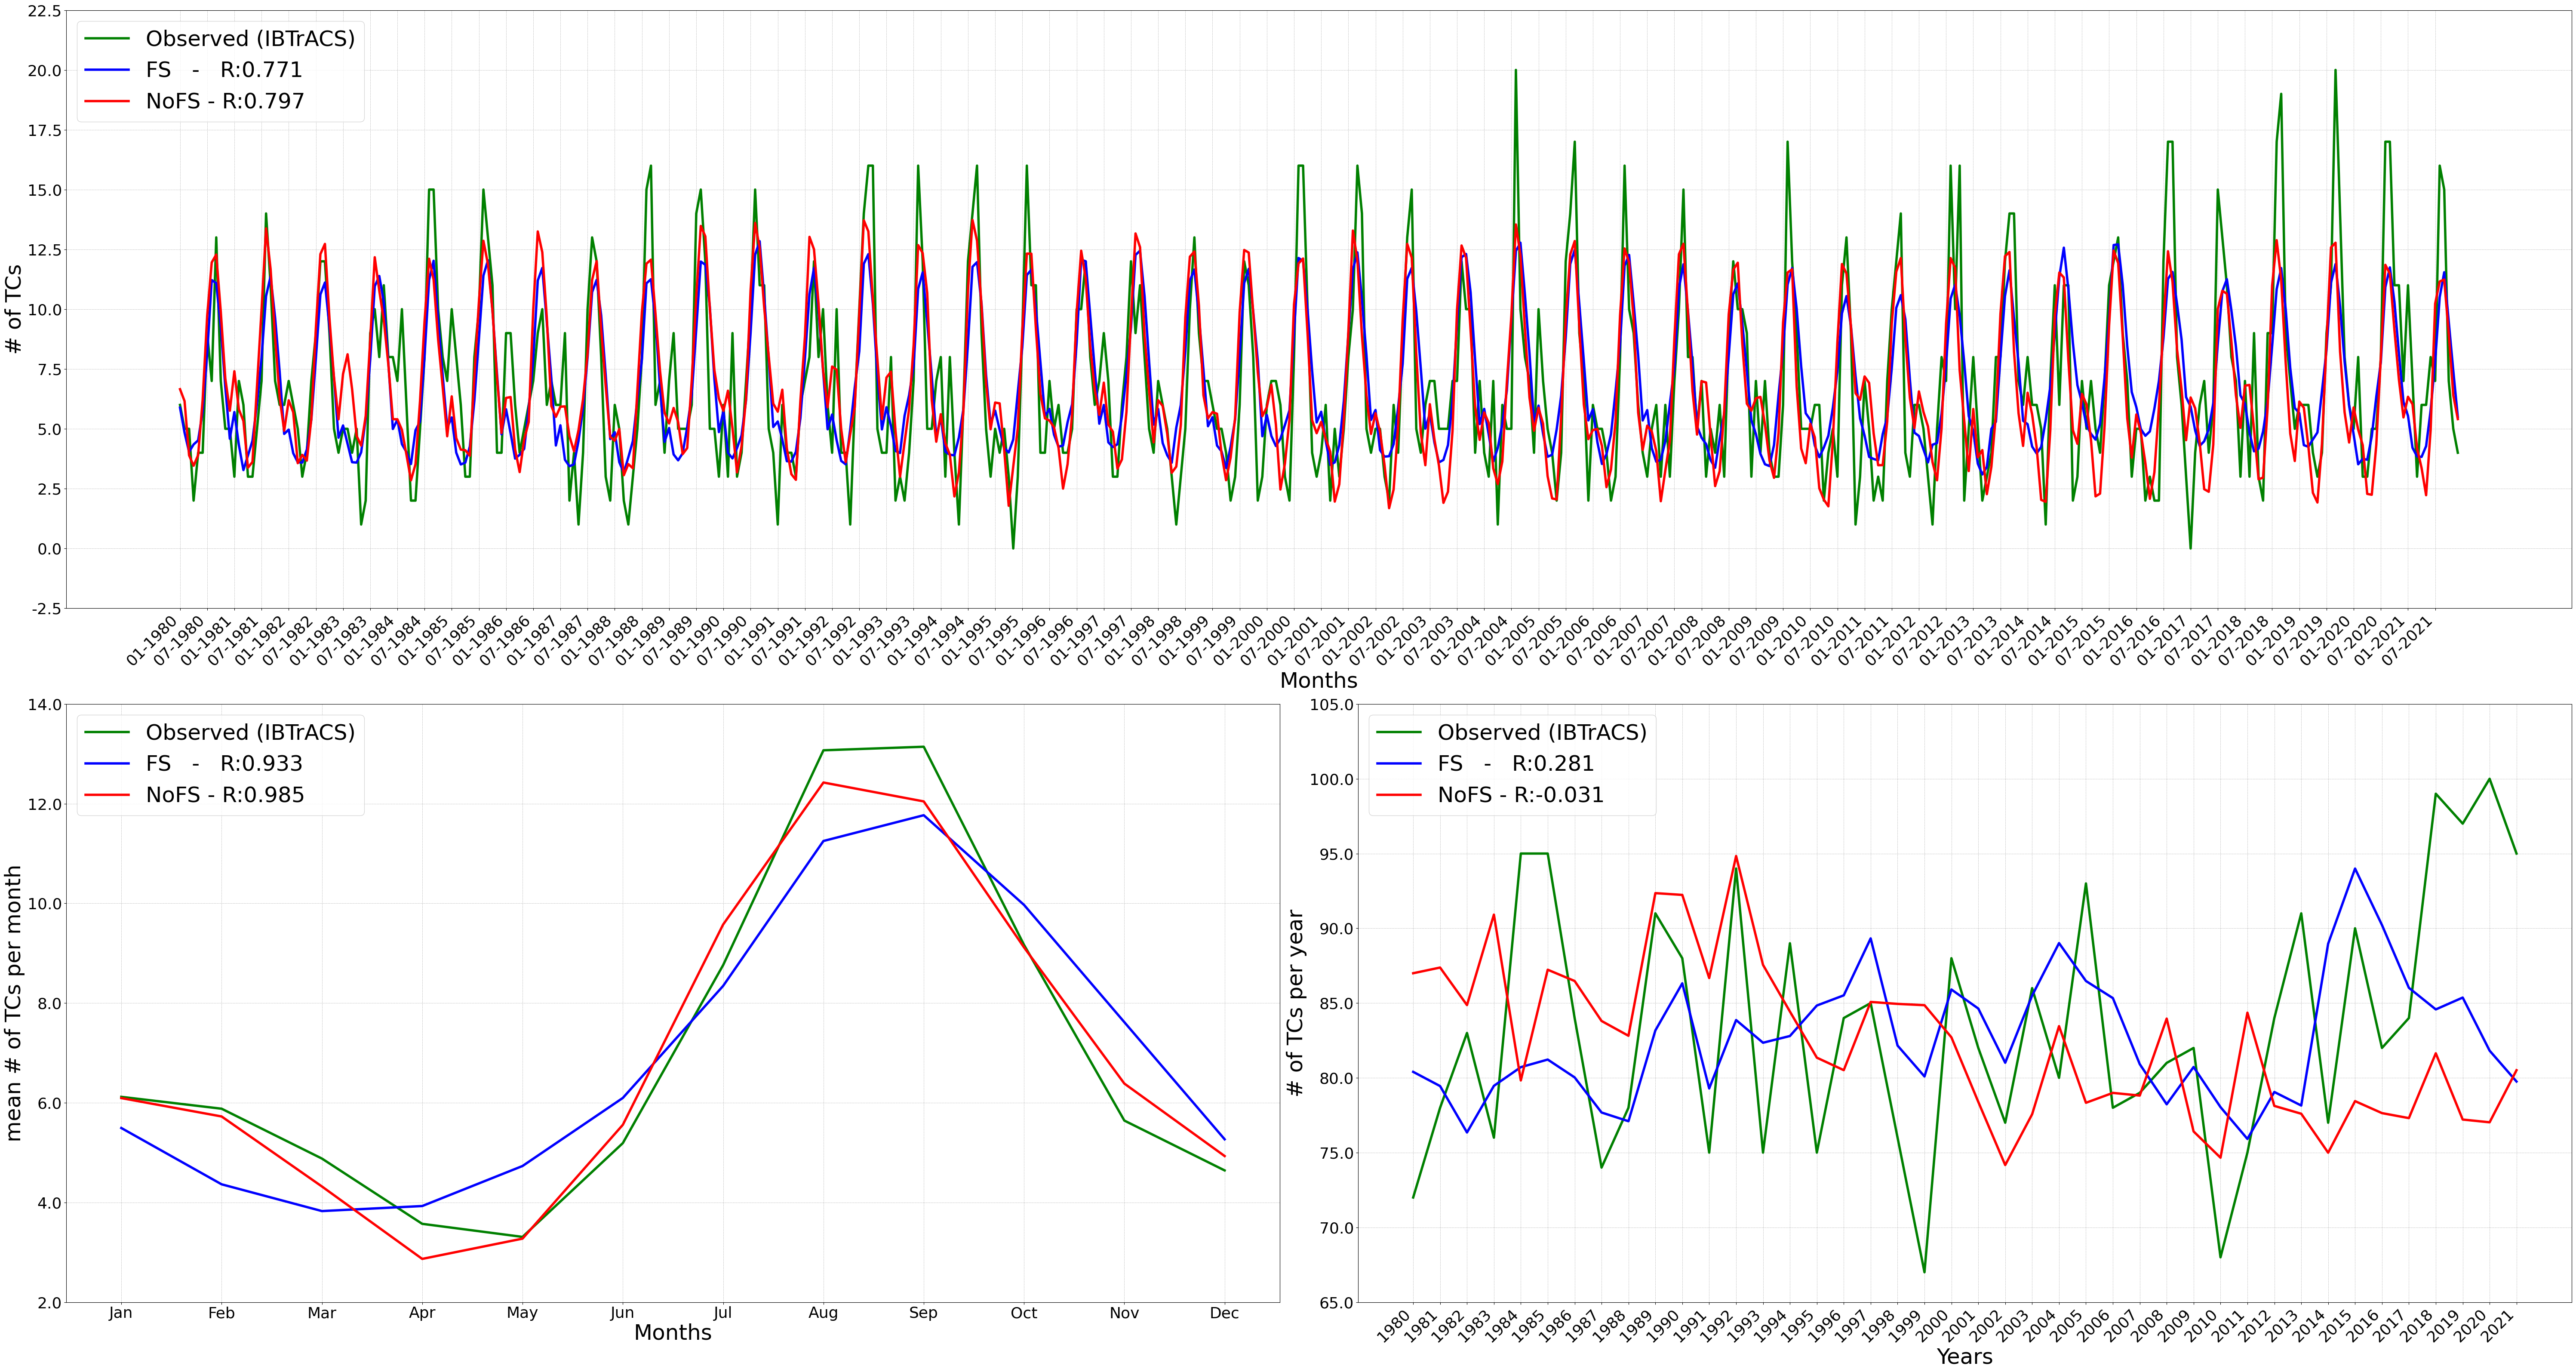

In [25]:
# Plot Time Series 
fig_ts = plt.figure(figsize=(60, 32))
gs = gridspec.GridSpec(2, 2, figure=fig_ts)
# monthly time series
ax = fig_ts.add_subplot(gs[0, :])
xticks = pd.Series(Y_test_df.index).dt.strftime('%m-%Y').to_numpy()
# observations
ax.plot(xticks, Y_test_df, label='Observed (IBTrACS)', color='green', linewidth=4)
# predictions
ax.plot(xticks, Y_pred_df['tcg'], label=f'FS   -   R:{r:.3f}', color='blue', linewidth=4)
ax.plot(xticks, Y_pred_noFS_df['tcg'], label=f'NoFS - R:{r_noFS:.3f}', color='red', linewidth=4)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(ticks=np.arange(len(xticks))[::6])
ax.set_xticklabels(xticks[::6], rotation=45, fontsize=26, ha='right')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=26)
ax.set_xlabel('Months', fontsize=36)
ax.set_ylabel('# of TCs', fontsize=36)
ax.legend(fontsize=36, loc='upper left')
# seasonal time series
axS = fig_ts.add_subplot(gs[1, 0])
# observations
axS.plot(Y_test_df_season.index, Y_test_df_season, label='Observed (IBTrACS)', color='green', linewidth=4)
# mlp predictions
axS.plot(Y_pred_df_season.index, Y_pred_df_season['tcg'], label=f'FS   -   R:{rS:.3f}', color='blue', linewidth=4)
axS.plot(Y_pred_noFS_df_season.index, Y_pred_noFS_df_season['tcg'], label=f'NoFS - R:{rS_noFS:.3f}', color='red', linewidth=4)
axS.grid(True, which='both', linestyle='--', linewidth=0.5)
axS.set_xticks(Y_test_df_season.index)
axS.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=26)
axS.set_yticks(axS.get_yticks())
axS.set_yticklabels(axS.get_yticks(), fontsize=26)
axS.set_xlabel('Months', fontsize=36)
axS.set_ylabel('mean # of TCs per month', fontsize=36)
axS.legend(fontsize=36, loc='upper left')
# Annual time series
axY = fig_ts.add_subplot(gs[1, 1])
# observations
axY.plot(Y_test_df_annual.index, Y_test_df_annual, label='Observed (IBTrACS)', color='green', linewidth=4)
# mlp predictions
axY.plot(Y_pred_df_annual.index, Y_pred_df_annual['tcg'], label=f'FS   -   R:{rY:.3f}', color='blue', linewidth=4)
axY.plot(Y_pred_noFS_df_annual.index, Y_pred_noFS_df_annual['tcg'], label=f'NoFS - R:{rY_noFS:.3f}', color='red', linewidth=4)
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(Y_test_df_annual.index)
axY.set_xticklabels(Y_test_df_annual.index, rotation=45, fontsize=26, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=26)
axY.set_xlabel('Years', fontsize=36)
axY.set_ylabel('# of TCs per year', fontsize=36)
axY.legend(fontsize=36, loc='upper left')

fig_ts.set_tight_layout(True)
plt.show()